In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import time
import os
import argparse
import gdreg
import matplotlib.pyplot as plt

# autoreload
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler
%load_ext line_profiler

In [2]:
JOB = "regress"
PGEN_FILE = "/n/groups/price/martin/WES_analysis/toy_1K/chr@_v1.SPB.hg19.toy_1K"
LD_FILE = "/n/groups/price/martin/WES_analysis/toy_1K/results/top_1K_chr@.ld.npy"
SUMSTATS_FILE = "/n/groups/price/martin/WES_analysis/toy_1K/sanity_rep0.sumstats.gz"
ANNOT_FILE = "/n/groups/price/martin/WES_analysis/toy_1K/toy.annot.gz," + \
    "/n/groups/price/martin/WES_analysis/toy_1K/toy.pannot.gz," + \
    "/n/groups/price/martin/WES_analysis/toy_1K/toy.pannot_hr.gz"
PREFIX_OUT = "/n/groups/price/martin/WES_analysis/toy_1K/results/toy_1K"
MEMORY = 64
RANDOM_SEED = 0
SNP_RANGE = None

In [3]:
sys_start_time = time.time()

###########################################################################################
######                                    Parse Options                              ######
###########################################################################################

# JOB = args.job
# PGEN_FILE = args.pgen_file
# LD_FILE = args.ld_file
# SUMSTATS_FILE = args.sumstats_file
# ANNOT_FILE = args.annot_file
# PREFIX_OUT = args.prefix_out
# MEMORY = args.memory
# RANDOM_SEED = args.random_seed
# SNP_RANGE = args.snp_range

# Parse and check arguments
LEGAL_JOB_LIST = ["compute_ld", "compute_score", "regress"]
err_msg = "# run_gdreg: --job=%s not supported" % JOB
assert JOB in LEGAL_JOB_LIST, err_msg

if JOB in ["compute_score", "regress"]:
    assert LD_FILE is not None, "--ld_file required for --job=%s" % JOB
if JOB in ["regress"]:
    assert SUMSTATS_FILE is not None, "--sumstats_file required for --job=%s" % JOB
if JOB in ["compute_score", "regress"]:
    assert ANNOT_FILE is not None, "--annot_file required for --job=%s" % JOB
if JOB in ["compute_ld"]:
    assert SNP_RANGE is not None, "--snp_range required for --job=%s" % JOB
    DIC_RANGE = gdreg.util.parse_snp_range(SNP_RANGE)

# Print input options
header = gdreg.util.get_cli_head()
header += "Call: run_gdreg.py \\\n"
header += "--job %s\\\n" % JOB
header += "--pgen_file %s\\\n" % PGEN_FILE
header += "--ld_file %s\\\n" % LD_FILE
header += "--sumstats_file %s\\\n" % SUMSTATS_FILE
header += "--annot_file %s\\\n" % ANNOT_FILE
header += "--prefix_out %s\\\n" % PREFIX_OUT
header += "--snp_range %s\\\n" % SNP_RANGE
header += "--memory %d\\\n" % MEMORY
header += "--random_seed %d\n" % RANDOM_SEED
print(header)

******************************************************************************
* Gene-level directional effect regression (GDReg)
* Version 0.0.2
* Martin Jinye Zhang
* HSPH / Broad Institute
* MIT License
******************************************************************************
Call: run_gdreg.py \
--job regress\
--pgen_file /n/groups/price/martin/WES_analysis/toy_1K/chr@_v1.SPB.hg19.toy_1K\
--ld_file /n/groups/price/martin/WES_analysis/toy_1K/results/top_1K_chr@.ld.npy\
--sumstats_file /n/groups/price/martin/WES_analysis/toy_1K/sanity_rep0.sumstats.gz\
--annot_file /n/groups/price/martin/WES_analysis/toy_1K/toy.annot.gz,/n/groups/price/martin/WES_analysis/toy_1K/toy.pannot.gz,/n/groups/price/martin/WES_analysis/toy_1K/toy.pannot_hr.gz\
--prefix_out /n/groups/price/martin/WES_analysis/toy_1K/results/toy_1K\
--snp_range None\
--memory 64\
--random_seed 0



In [4]:
###########################################################################################
######                                   Data Loading                                ######
###########################################################################################
# Load --pgen_file
if JOB in ["compute_ld", "compute_score", "regress"]:
    print("# Loading --pgen_file")
    dic_data = {}
    if "@" not in PGEN_FILE:
        temp_dic = gdreg.util.read_pgen(PGEN_FILE)
        dic_data[temp_dic["pvar"]["CHR"][0]] = temp_dic.copy()
    else:
        for CHR in range(1, 23):
            if os.path.exists(PGEN_FILE.replace("@", "%s" % CHR) + ".pgen"):
                dic_data[CHR] = gdreg.util.read_pgen(
                    PGEN_FILE.replace("@", "%s" % CHR)
                )

    for CHR in dic_data:
        n_sample = dic_data[CHR]["psam"].shape[0]
        n_snp = dic_data[CHR]["pvar"].shape[0]
        mat_X = gdreg.util.read_geno(
            dic_data[CHR]["pgen"], 0, 50, n_sample=None, n_snp=None
        )
        sparsity = (mat_X != 0).mean()
        print(
            "    CHR%2d: %d samples, %d SNPs, %0.1f%% non-zeros for first 50 SNPs"
            % (CHR, n_sample, n_snp, sparsity * 100)
        )
    print("    " + gdreg.util.get_sys_info(sys_start_time))

# Load --ld_file
if JOB in ["compute_score", "regress"]:
    print("# Loading --ld_file")
    dic_ld = {}
    for CHR in dic_data:
        err_msg = "--ld_file missing for CHR%d" % CHR
        assert os.path.exists(LD_FILE.replace("@", "%s" % CHR)), err_msg
        dic_ld[CHR] = np.load(LD_FILE.replace("@", "%s" % CHR))  # TODO : sp.sparse
        err_msg = "CHR%2d n_snp=%d, mismatch with --pgen_file" % (
            CHR,
            dic_ld[CHR].shape[0],
        )
        assert dic_ld[CHR].shape[0] == dic_data[CHR]["pvar"].shape[0], err_msg
    print("    LD info loaded, matching --pgen_file")
    print("    " + gdreg.util.get_sys_info(sys_start_time))

# Load --sumstats_file
if JOB in ["regress"]:
    print("# Loading --sumstats_file")
    df_sumstats = pd.read_csv(SUMSTATS_FILE, sep="\t", index_col=None)
    print("    .sumstats.gz loaded, %d SNPs" % df_sumstats.shape[0])
    print("    " + gdreg.util.get_sys_info(sys_start_time))

# Load --annot_file
if JOB in ["compute_score", "regress"]:
    print("# Loading --annot_file")
    df_annot = None
    pannot_list = []
    pannot_hr_list = []
    for annot_file in ANNOT_FILE.split(","):
        err_msg = "--annot_file missing : '%s'" % annot_file
        assert os.path.exists(annot_file), err_msg
        temp_df = gdreg.util.read_annot(annot_file)

        if annot_file.endswith(".annot.gz"):
            temp_df.index = temp_df["SNP"]
            if df_annot is None:
                df_annot = temp_df.copy()
            else:
                col_list = [x for x in temp_df if x.startswith("AN:")]
                df_annot = df_annot.join(temp_df[col_list])
        if annot_file.endswith(".pannot.gz"):
            pannot_list.append(temp_df.copy())
        if annot_file.endswith(".pannot_hr.gz"):
            pannot_hr_list.append(temp_df.copy())
    AN_list = [x for x in df_annot if x.startswith("AN:")]
    print(
        "    .annot.gz (%d SNPs and %d annots): %s"
        % (df_annot.shape[0], len(AN_list), ",".join(AN_list))
    )
    temp_list = ["%s (%d SNPs)" % (x.columns[-1], x.shape[0]) for x in pannot_list]
    print(
        "    .pannot.gz (%d pannots): %s" % (len(pannot_list), ",".join(temp_list)),
    )
    temp_list = [
        "%s (%d pairs)" % (x.columns[-1], x.shape[0]) for x in pannot_hr_list
    ]
    print(
        "    .pannot_hr.gz (%d pannots): %s"
        % (len(pannot_hr_list), ",".join(temp_list)),
    )
    print("    " + gdreg.util.get_sys_info(sys_start_time))

# Loading --pgen_file
    CHR 1: 5000 samples, 4349 SNPs, 27.3% non-zeros for first 50 SNPs
    CHR 2: 5000 samples, 4192 SNPs, 43.5% non-zeros for first 50 SNPs
    CHR 3: 5000 samples, 4191 SNPs, 34.2% non-zeros for first 50 SNPs
    CHR 4: 5000 samples, 4149 SNPs, 24.6% non-zeros for first 50 SNPs
    CHR 5: 5000 samples, 4240 SNPs, 36.7% non-zeros for first 50 SNPs
    CHR 6: 5000 samples, 4280 SNPs, 38.5% non-zeros for first 50 SNPs
    CHR 7: 5000 samples, 4200 SNPs, 41.7% non-zeros for first 50 SNPs
    CHR 8: 5000 samples, 3996 SNPs, 33.1% non-zeros for first 50 SNPs
    CHR 9: 5000 samples, 4258 SNPs, 41.3% non-zeros for first 50 SNPs
    CHR10: 5000 samples, 4243 SNPs, 41.1% non-zeros for first 50 SNPs
    sys_time=2.6s, sys_mem=0.1GB
# Loading --ld_file
    LD info loaded, matching --pgen_file
    sys_time=15.7s, sys_mem=0.77GB
# Loading --sumstats_file
    .sumstats.gz loaded, 42098 SNPs
    sys_time=15.8s, sys_mem=0.77GB
# Loading --annot_file
    .annot.gz (42098 SNPs and

In [8]:
df_score = gdreg.score.compute_score(
    dic_data, 
    dic_ld,
    df_annot,
    verbose = True,
    win_size = 1e7,
    memory=512
)

# Call: gdreg.score.compute_score
    42098 SNPs from 10 CHRs: CHR1 (4349 SNPs), CHR2 (4192 SNPs), CHR3 (4191 SNPs), CHR4 (4149 SNPs), CHR5 (4240 SNPs), CHR6 (4280 SNPs), CHR7 (4200 SNPs), CHR8 (3996 SNPs), CHR9 (4258 SNPs), CHR10 (4243 SNPs)
    Single-SNP annots : AN:ALL, AN:CHR1, AN:ODD
    SNP-pair annots : 
    win_size=10.0MB, memory=512MB
    Completed, time=39.3s


In [18]:
dic_res = gdreg.regress.estimate(
    dic_data,
    df_sumstats,
    dic_ld,
    df_annot,
    pannot_list=pannot_list,
    pannot_hr_list=pannot_hr_list,
    df_score=df_score,
    n_jn_block=100,
    sym_non_pAN="non-pAN",
    win_size=int(1e7),
    memory=512,
    verbose=True,
    n_iter=10,
)

# print(dic_res['term'])
# print(dic_res['coef'])
# print(dic_res['coef_jn'])
# print(np.sqrt(np.diag(dic_res['coef_jn_cov'])))

# Call: gdreg.regress.estimate
    dic_data : n_snp=42098, n_sample=42098
    df_sumstats : n_snp=42098, n_sample_zsq=5000
    Remove duplicates or ZSQ>80.0 SNPs, 42098 remaining, avg. zsq=1.48
    Regression : n_snp=42098, n_block=103
# Call: gdreg.regress.regress
    n_snp=42098, n_block=103, n_sample_zsq=5000
    4 regressors : LD:AN:ALL, LD:AN:CHR1, LD:AN:ODD, E
    Completed, time=0.0s
# Call: gdreg.score.compute_score
    42098 SNPs from 10 CHRs: CHR1 (4349 SNPs), CHR2 (4192 SNPs), CHR3 (4191 SNPs), CHR4 (4149 SNPs), CHR5 (4240 SNPs), CHR6 (4280 SNPs), CHR7 (4200 SNPs), CHR8 (3996 SNPs), CHR9 (4258 SNPs), CHR10 (4243 SNPs)
    Single-SNP annots : AN:ALL, AN:CHR1, AN:ODD
    SNP-pair annots : pAN:gene, pAN:proxy (hr)
    win_size=10.0MB, memory=512MB
    Completed, time=67.8s
# Call: gdreg.regress.regress
    n_snp=42098, n_block=103, n_sample_zsq=5000
    10 regressors : LD:AN:ALL, LD:AN:CHR1, LD:AN:ODD, DLD:pAN:gene|AN:ALL, DLD:pAN:gene|AN:CHR1, DLD:pAN:gene|AN:ODD, DLD:pAN:prox

In [19]:
df_res = pd.DataFrame(index=dic_res['rho_0']['term'], columns=dic_res.keys(), dtype=float)
df_res_se = pd.DataFrame(index=dic_res['rho_0']['term'], columns=dic_res.keys(), dtype=float)
for res in dic_res:
    df_res.loc[dic_res[res]['term'], res] = dic_res[res]['coef_jn']
    df_res_se.loc[dic_res[res]['term'], res] = np.diag(dic_res[res]['coef_jn_cov'])**0.5


# plt.figure()
# for ter
# plt.show()


In [33]:
dic_res_all = {}
for rep in range(10):
    print(rep)    
    df_sumstats = pd.read_csv('/n/groups/price/martin/WES_analysis/toy_1K/sanity_rep%d.sumstats.gz'%rep, 
                              sep="\t", index_col=None)
    
    dic_res_all[rep] = gdreg.regress.estimate(
        dic_data,
        df_sumstats,
        dic_ld,
        df_annot,
        pannot_list=pannot_list,
        pannot_hr_list=pannot_hr_list,
        df_score=df_score,
        n_jn_block=100,
        sym_non_pAN="non-pAN",
        win_size=int(1e7),
        memory=512,
        verbose=False,
        n_iter=3,
    )

0
1


/home/jz286/WES_analysis/GDReg/gdreg/score.py:321: RuntimeWarning: invalid value encountered in sqrt
  v_ps_sd = np.sqrt(np.array(v_ps_sd, dtype=np.float32))


2
3
4
5
6
7
8
9


In [63]:
dic_df_res = {}
dic_df_res_se = {}
for rep in dic_res_all:
    dic_res = dic_res_all[rep]
    df_res = pd.DataFrame(index=dic_res['rho_0']['term'], columns=dic_res.keys(), dtype=float)
    df_res_se = pd.DataFrame(index=dic_res['rho_0']['term'], columns=dic_res.keys(), dtype=float)
    for res in dic_res:
        df_res.loc[dic_res[res]['term'], res] = dic_res[res]['coef_jn']
        df_res_se.loc[dic_res[res]['term'], res] = np.diag(dic_res[res]['coef_jn_cov'])**0.5
        
    dic_df_res[rep] = df_res.copy()
    dic_df_res_se[rep] = df_res_se.copy()

In [38]:
# Check convergence 



,tau,rho_0,rho_1,rho_2
LD:AN:ALL,0.000003,4.162411e-06,4.162411e-06,4.162412e-06
LD:AN:CHR1,0.000014,2.534023e-07,2.534028e-07,2.534028e-07
LD:AN:ODD,0.000006,7.078997e-06,7.078999e-06,7.079000e-06
DLD:pAN:gene|AN:ALL,NaN,4.965392e-01,3.267623e-01,3.267623e-01
DLD:pAN:gene|AN:CHR1,NaN,2.422905e+00,4.848351e+00,4.848350e+00
DLD:pAN:gene|AN:ODD,NaN,-3.553933e-01,-2.197148e-01,-2.197148e-01
DLD:pAN:proxy|AN:ALL,NaN,-9.712278e-02,-6.391455e-02,-6.391455e-02
DLD:pAN:proxy|AN:CHR1,NaN,1.976524e-02,-1.673888e-02,-1.673888e-02
DLD:pAN:proxy|AN:ODD,NaN,5.033621e-02,2.843072e-02,2.843073e-02
E,0.844085,7.845671e-01,7.845670e-01,7.845671e-01


In [81]:
v_se

array([3.77602100e-06, 3.03109550e-06, 4.13413682e-06, 2.88197339e-06,
       5.11189410e-06, 4.70970326e-06, 3.92850461e-06, 3.88332364e-06,
       4.20081051e-06])

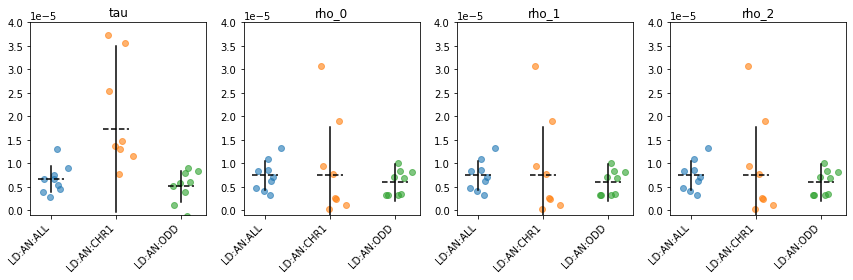

In [83]:
# Check calibration
plot_list = ['LD:AN:ALL', 'LD:AN:CHR1', 'LD:AN:ODD']
v_jitter = np.random.randn(9)*0.1
v_rep = np.array([0]+list(np.arange(2,10)))
plt.figure(figsize=[12,4])
for i_res,res in enumerate(['tau', 'rho_0', 'rho_1', 'rho_2']):
    plt.subplot(1,4,i_res+1)
    for i_term,term in enumerate(plot_list):
        v_val = np.array([dic_df_res[x].loc[term, res] for x in v_rep])
        mean_ = v_val.mean()
        v_se = np.array([dic_df_res_se[x].loc[term, res] for x in v_rep])
        plt.scatter(v_jitter+i_term, v_val, alpha=0.6)
        plt.plot([i_term-0.2, i_term+0.2], [mean_, mean_], '--', color='k', zorder=10)
        plt.plot([i_term, i_term], [mean_-v_se.mean(), mean_+v_se.mean()], color='k', zorder=10)
        
    
    plt.title(res)
    plt.ylim([-0.1e-5, 4e-5])
    plt.xticks(np.arange(len(plot_list)), plot_list, rotation=45, ha='right')
plt.tight_layout()
plt.show()


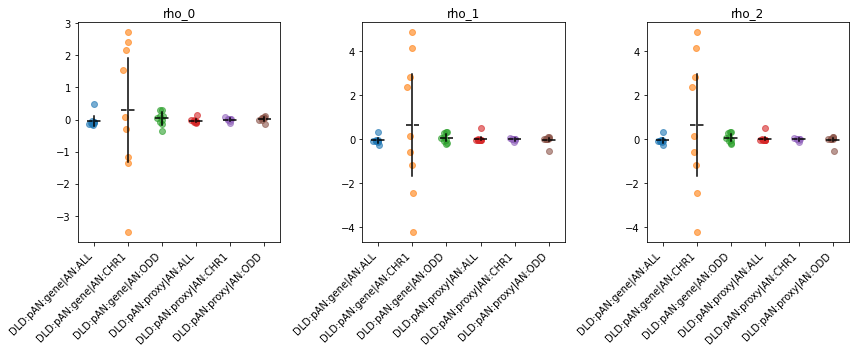

In [89]:
plot_list = ['DLD:pAN:gene|AN:ALL', 'DLD:pAN:gene|AN:CHR1', 'DLD:pAN:gene|AN:ODD', 
             'DLD:pAN:proxy|AN:ALL', 'DLD:pAN:proxy|AN:CHR1', 'DLD:pAN:proxy|AN:ODD']
v_jitter = np.random.randn(9)*0.1
v_rep = np.array([0]+list(np.arange(2,10)))
plt.figure(figsize=[12,5])
for i_res,res in enumerate(['rho_0', 'rho_1', 'rho_2']):
    plt.subplot(1,3,i_res+1)
    for i_term,term in enumerate(plot_list):
        v_val = np.array([dic_df_res[x].loc[term, res] for x in v_rep])
        mean_ = v_val.mean()
        v_se = np.array([dic_df_res_se[x].loc[term, res] for x in v_rep])
        plt.scatter(v_jitter+i_term, v_val, alpha=0.6)
        plt.plot([i_term-0.2, i_term+0.2], [mean_, mean_], '--', color='k', zorder=10)
        plt.plot([i_term, i_term], [mean_-v_se.mean(), mean_+v_se.mean()], color='k', zorder=10)
        
    
    plt.title(res)
#     plt.ylim([-1, 1])
    plt.xticks(np.arange(len(plot_list)), plot_list, rotation=45, ha='right')
plt.tight_layout()
plt.show()

### gdreg.regress.get_block

In [40]:
temp_df = pd.DataFrame(data={
    'CHR' : [1,1,1,1,1,1,1,2,2,2,2,2,3,3],
})
temp_pannot_list = [
    pd.DataFrame(data={
    'pAN:gene' : [
        'a','a','a','non-pAN','c', 'c', 'non-pAN',
        'non-pAN', 'b','b','b','b',
        'non-pAN','non-pAN'
    ],
})
]
gdreg.regress.get_block(temp_df, temp_pannot_list, n_block=3)

{0: (0, 6), 1: (6, 7), 2: (7, 12), 3: (12, 14)}

### Does the data look OK???

In [9]:
df_eff = pd.read_csv("/n/groups/price/martin/WES_analysis/toy_1K/sanity_nd_rep0.eff.gz", sep='\t')
dic_eff = { x: y**2 for x, y in zip(df_eff["SNP"], df_eff["EFF"]) }
dic_zsq = { x: y**2 for x, y in zip(df_sumstats["SNP"], df_sumstats["Z"])}

temp_df = df_score.copy()
temp_df['ZSQ'] = [dic_zsq[x] for x in temp_df['SNP']]
temp_df['EFFSQ'] = [dic_eff[x] for x in temp_df['SNP']]

In [19]:
(temp_df['EFFSQ']).sum()

0.4894335692078715

In [32]:
print(temp_df.loc[temp_df['CHR']==1, 'ZSQ'].mean(), temp_df.loc[temp_df['CHR']==1, 'EFFSQ'].mean())

KeyError: 'ZSQ'

In [15]:
print(temp_df.loc[temp_df['CHR']%2==0, 'ZSQ'].mean(), temp_df.loc[temp_df['CHR']%2==0, 'EFFSQ'].mean())

1.039649622100858 6.992735878720677e-06


In [16]:
print(temp_df.loc[temp_df['CHR']%2==1, 'ZSQ'].mean(), temp_df.loc[temp_df['CHR']%2==1, 'EFFSQ'].mean())

1.103828699394063 1.5495125005248987e-05


### Global LD score : gives the same result

In [ ]:
# Read in all LD matrices 
dic_ld_full = {}
temp_path = "/n/groups/price/martin/WES_analysis/toy_1K/results/full_ld"
for CHR in range(1,11):
    for CHR_REF in range(1,11):
        dic_ld_full[(CHR,CHR_REF)] = np.load(
            temp_path + '/top_1K_chr%d_chr%d.ld.npy' % (CHR, CHR_REF)
        )
        
# df_score_g
df_score_g = df_score.copy()
for CHR in range(1,11):
    mat_ld_chr = np.concatenate([dic_ld_full[(CHR,x)] for x in range(1,11)], axis=0)
    for AN in ['AN:ALL', 'AN:CHR1', 'AN:ODD']:
        v_annot = df_annot[AN].values
        v_ld_score = ((mat_ld_chr**2).T*v_annot).sum(axis=1)
        df_score_g.loc[df_score_g['CHR']==CHR, 'LD:%s'%AN] = v_ld_score
        